<font face="Chalkboard" color="darkgreen" size=6pt> Locally Weighted Linear Regression (part 2)</font>

The main idea is that we want to use many different kernels for the weights and compare the results.

In [1]:
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

Definition of the kernels:
https://en.wikipedia.org/wiki/Kernel_(statistics)

The main idea of linear regression is the assumption that:

$$\large y = X\cdot\beta +\sigma\epsilon $$

If we pre-multiply this equation with a matrix of weights (the "weights" are on the main diagonal and the rest of the elements are 0) we get:

$$\large W(i)y = W(i)X\cdot\beta +\sigma W(i)\epsilon $$

The independent observations are the rows of the matrix $X$. Each row has a number of columns (this is the number of features) and we can denote it by $p.$ As such, every row is a vector in $\mathbb{R}^p$ The distance between two independent observations is the Euclidean distance between the two represented $p-$dimensional vectors. The equation is:

$$\large dist(\vec{v},\vec{w})=\sqrt{(v_1-w_1)^2+(v_2-w_2)^2+...(v_p-w_p)^2}$$

We shall have $n$ different weight vectors because we have $n$ different observations.

**Important aspect**: linear regression can be seen as a linear combination of the observed outputs (values of the dependent variable).

We have:

$$\large  X^Ty = X^TX\beta +\sigma X^T\epsilon$$

We solve for $\beta$ (by assuming that $X^TX$ is invertible):

$$\large \beta = (X^TX)^{-1}(X^Ty) - \sigma (X^TX)^{-1}X^T\epsilon$$

We take the expected value of this equation and obtain the expected value of the coeffcients:

$$\large \bar{\beta} = (X^TX)^{-1}(X^Ty)$$

Therefore the predictions we make are:

$$\large \hat{y} = X(X^TX)^{-1}(X^Ty)$$

For the locally weighted regression we have 

$$\large \hat{y} = X(X^TWX)^{-1}(X^TWy)$$

The Big Idea: the predictions we make are a linear combination of the actual observed values of the dependent variable!

For locally weighted regression, $\hat{y}$ is obtained as a different linear combination of the values of y.

In [3]:
x = np.arange(-1.5,1.51,0.01)

In [ ]:
x

In [4]:
# Tricubic Kernel
def tricubic(x):
  return np.where(np.abs(x)>1,0,70/81*(1-np.abs(x)**3)**3)

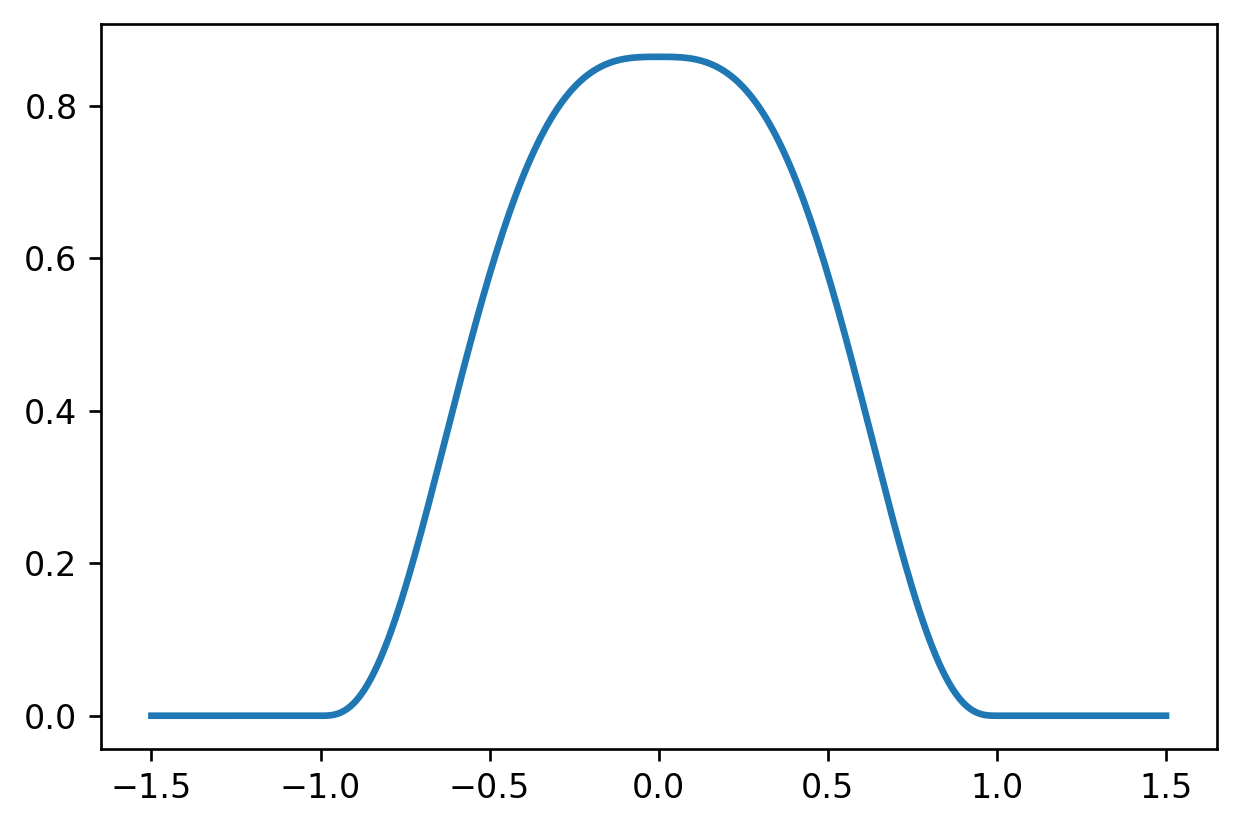

In [5]:
y = tricubic(x)
fig, ax = plt.subplots()
ax.plot(x,y,lw=2)
plt.show()

In [6]:
# Epanechnikov Kernel
def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2)) 

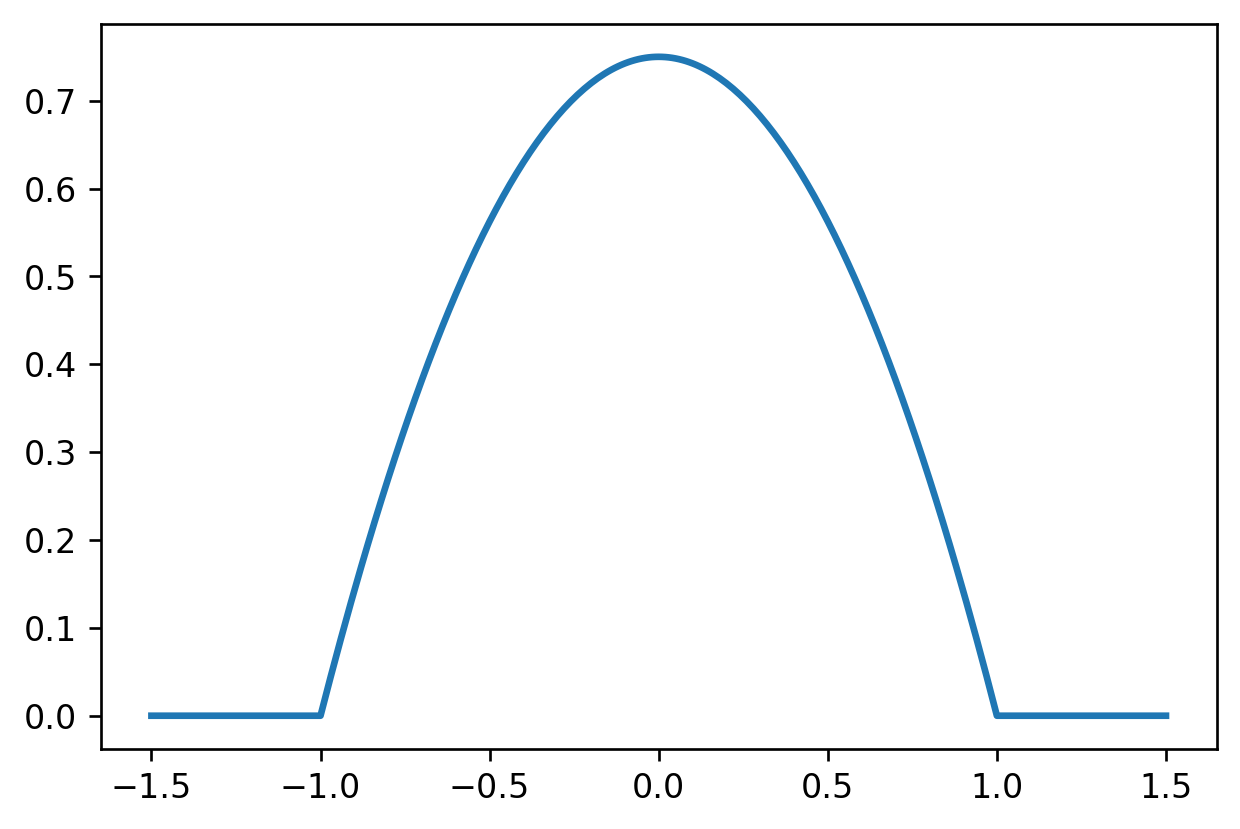

In [7]:
y = Epanechnikov(x)
fig, ax = plt.subplots()
ax.plot(x,y,lw=2)
plt.show()

In [8]:
# Quartic Kernel
def Quartic(x):
  return np.where(np.abs(x)>1,0,15/16*(1-np.abs(x)**2)**2) 

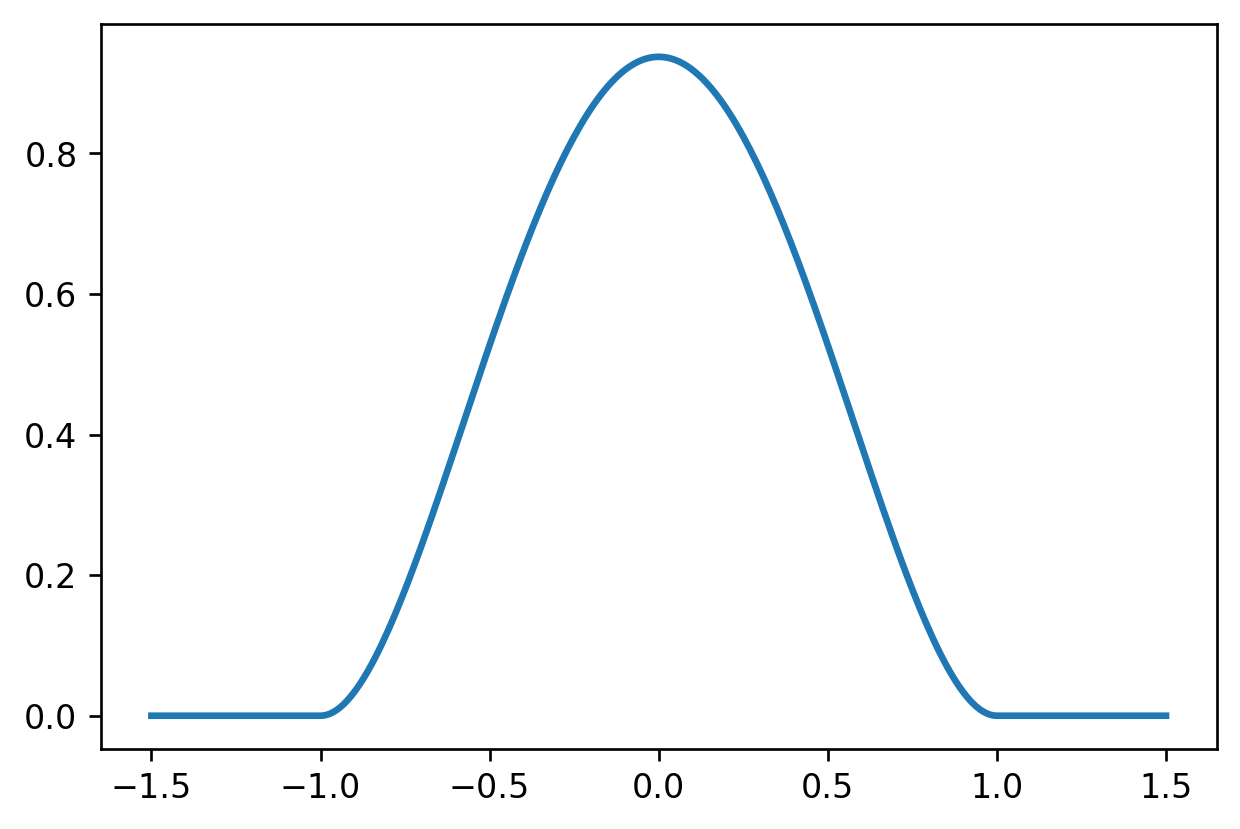

In [9]:
y = Quartic(x)
fig, ax = plt.subplots()
ax.plot(x,y,lw=2)
plt.show()

And the list of useful kernels may continue..

What we want is to apply different kernels to Locally Weighted Regression. We want to turn weak learners into strong ones.

In [10]:
#Defining the kernel function - used for plotting later on


def kernel_function(xi,x0,kern, tau): 
    return kern((xi - x0)/(2*tau))

def lowess_kern(x, y, kern, tau):
    # tau is called bandwidth K((x-x[i])/(2*tau))
    # IMPORTANT: we expect x to the sorted increasingly
    # tau is a hyper-parameter
    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the bell shape kernel function    
    w = np.array([kern((x - x[i])/(2*tau)) for i in range(n)])     
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        beta = linalg.solve(A, b) # A*beta = b
        # beta, res, rnk, s = linalg.lstsq(A, b)
        yest[i] = beta[0] + beta[1] * x[i] 

    return yest

In [11]:
# approach by Alex Gramfort

def lowess_ag(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

In [12]:
#Initializing noisy non linear data
x = np.linspace(0,4,400)
noise = np.random.normal(loc = 0, scale = .8, size = 400)
y = np.sin(x**2 * 1.5 * np.pi ) 
y_noise = y + noise

In [13]:
xlr = x.reshape(-1,1)
y_noiselr = y_noise.reshape(-1,1)

In [14]:
lr = LinearRegression()
lr.fit(xlr,y_noiselr)

LinearRegression()

In [15]:
# we want to compare with linear regression
yhat_lr = lr.predict(xlr)

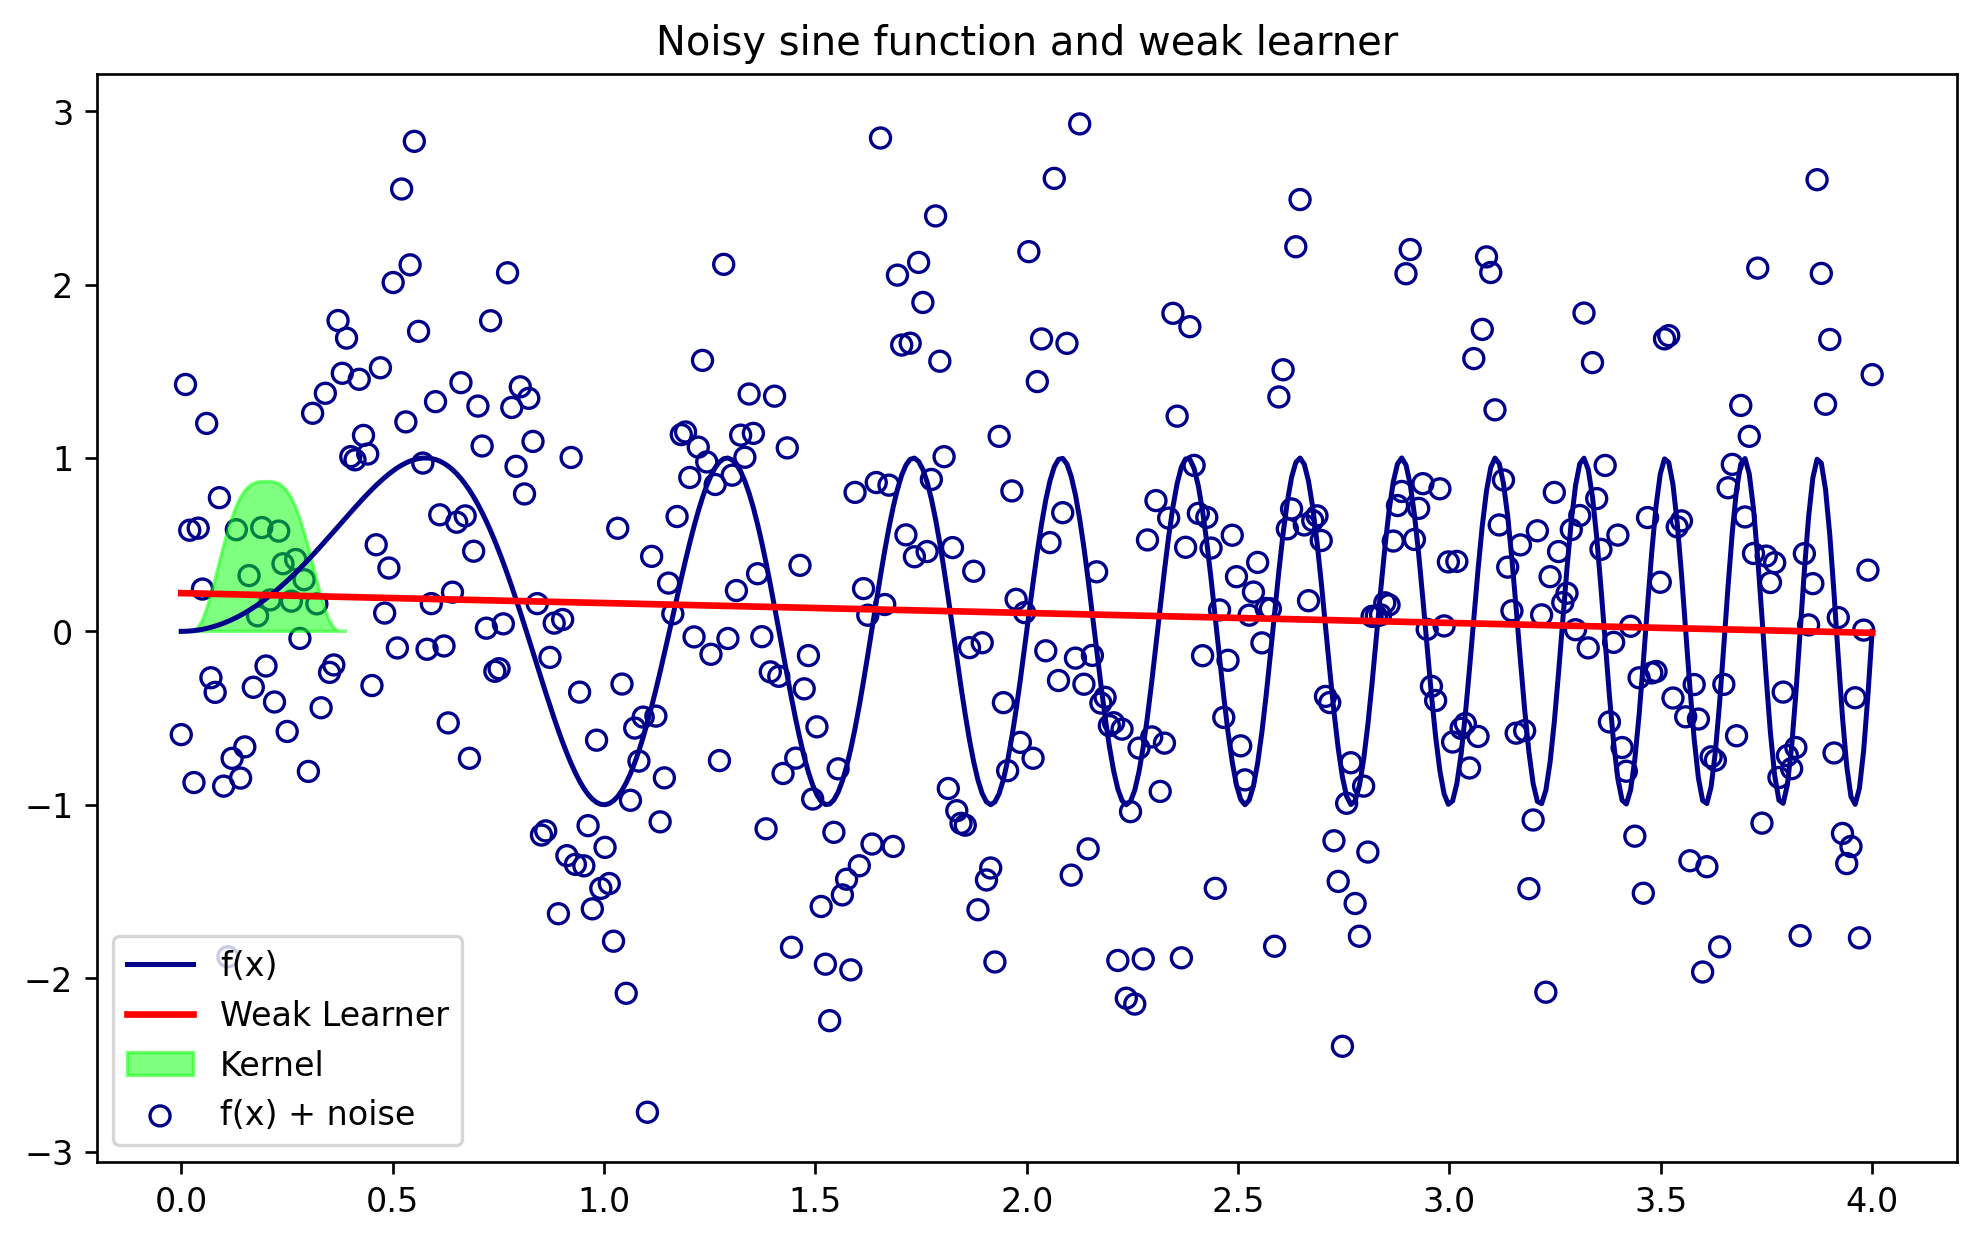

In [16]:
#Plotting the noisy data and the kernell at around x = 0.2
plt.figure(figsize=(10,6))
plt.plot(x,y,color = 'darkblue', label = 'f(x)')
plt.plot(xlr,yhat_lr,color='red',lw=2,label = 'Weak Learner')
plt.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'f(x) + noise')
plt.fill(x[:40],kernel_function(x[:40],0.2,tricubic,.09), color = 'lime', alpha = .5, label = 'Kernel')
plt.legend()
plt.title('Noisy sine function and weak learner')
plt.show()

In [29]:
## here is where we make predictions with our kernel
tau = 0.009

yhat_kern = lowess_kern(x,y,tricubic,tau)

f = 0.02
yest = lowess_ag(x, y, f=f, iter=3)

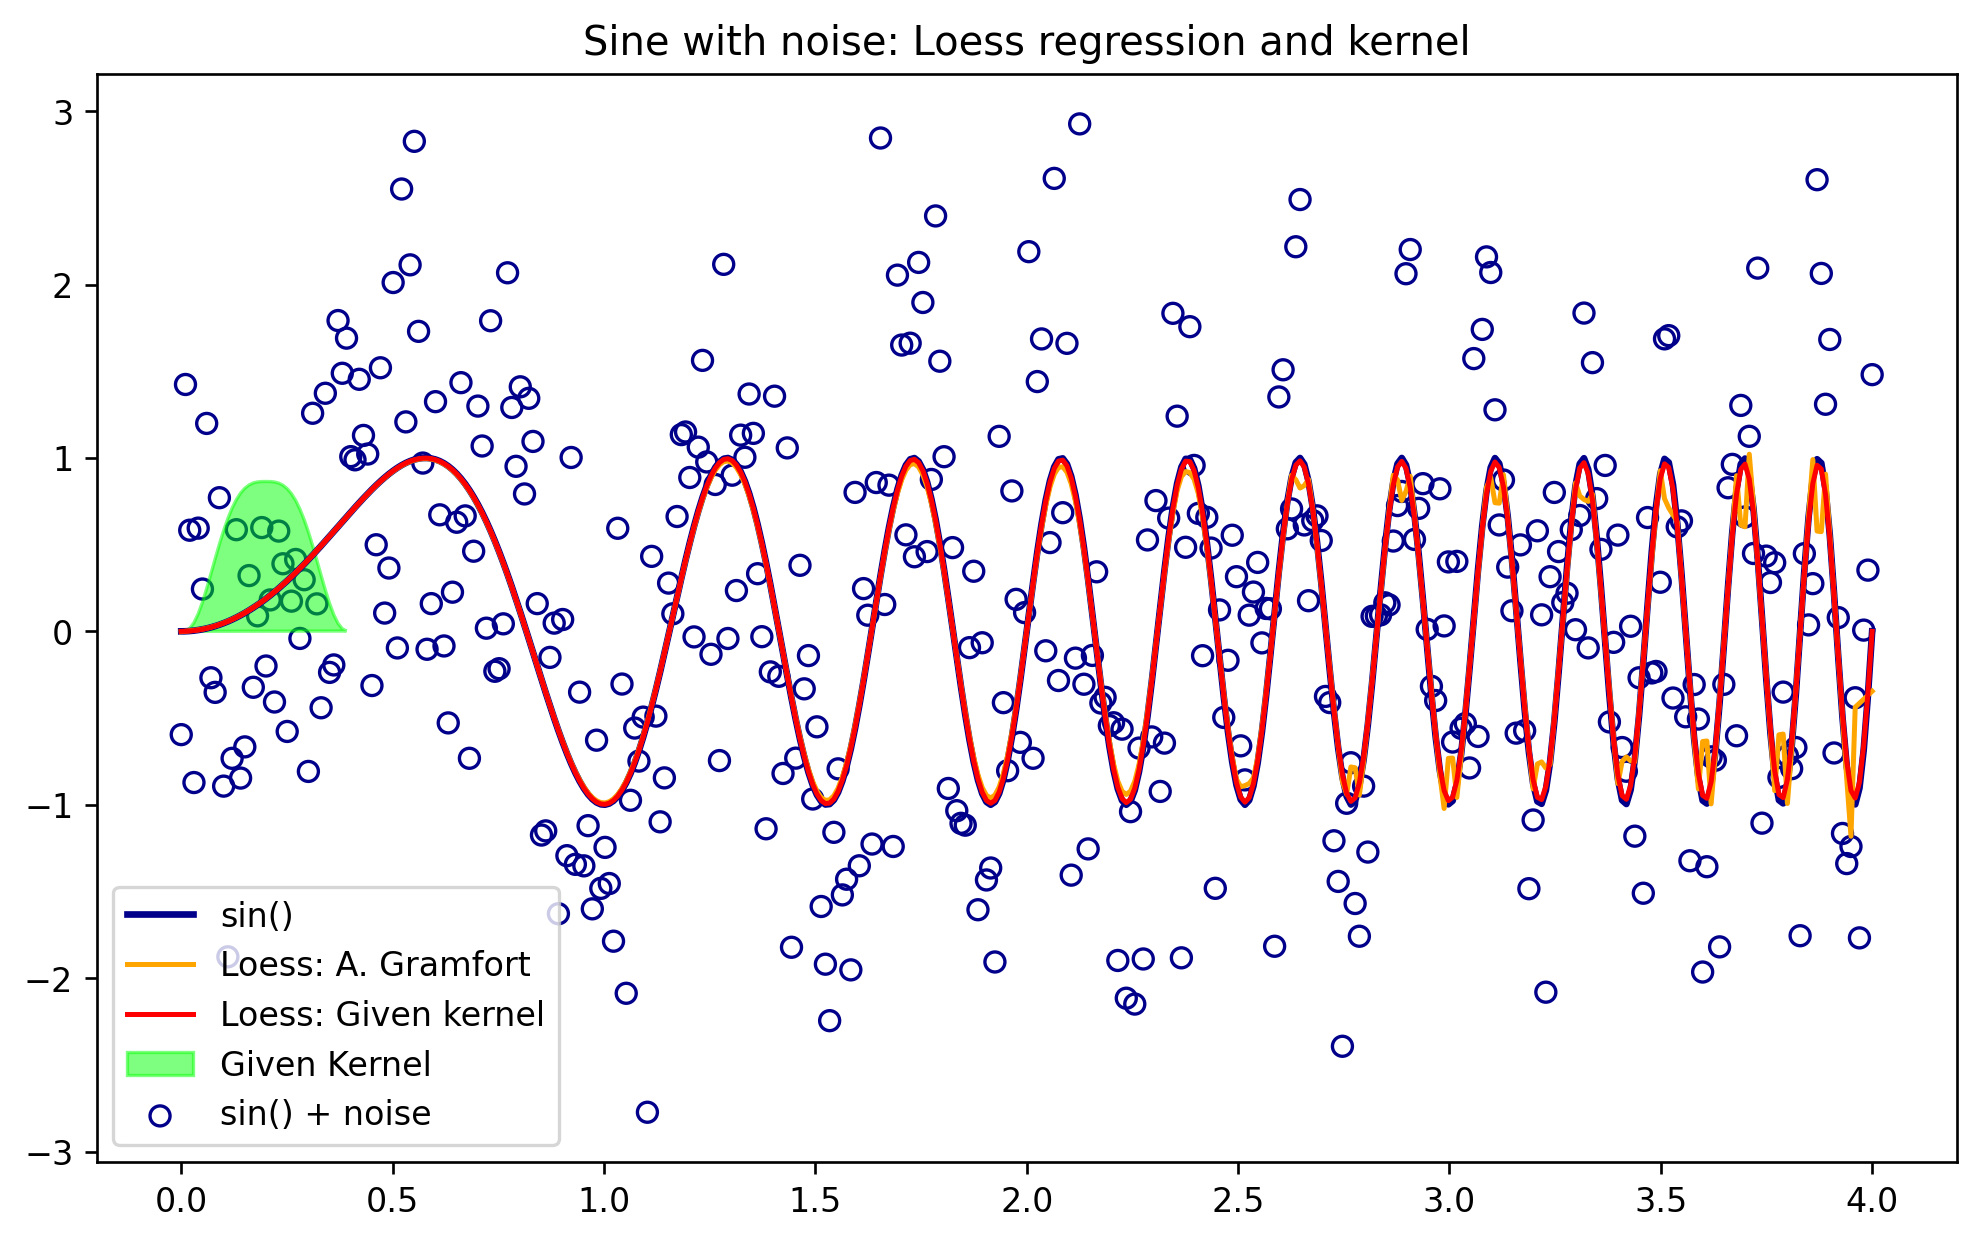

In [30]:
plt.figure(figsize=(10,6))
plt.plot(x,y,color = 'darkblue', label = 'sin()',lw=2)
plt.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'sin() + noise')
plt.fill(x[:40],kernel_function(x[:40],0.2,tricubic,0.1), color = 'lime', alpha = .5, label = 'Given Kernel')
plt.plot(x,yest,color = 'orange', label = 'Loess: A. Gramfort')
plt.plot(x,yhat_kern,color = 'red', label = 'Loess: Given kernel')
plt.legend()
plt.title('Sine with noise: Loess regression and kernel')
plt.show()

##<font face='menlo' size=6pt> Applications with Real Data </font>

First let's make a more usable function:

In [ ]:
def lowess_reg(x, y, xnew, kern, tau):
    # tau is called bandwidth K((x-x[i])/(2*tau))
    # IMPORTANT: we expect x to the sorted increasingly
    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the bell shape kernel function    
    w = np.array([kern((x - x[i])/(2*tau)) for i in range(n)])     
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        #theta = linalg.solve(A, b) # A*theta = b
        theta, res, rnk, s = linalg.lstsq(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 
    f = interp1d(x, yest,fill_value='extrapolate')
    return f(xnew)
   

In [ ]:
lowess_reg(x,y,2.63,tricubic,0.01)

array(213.93)

In [ ]:
data = pd.read_csv('drive/MyDrive/Data Sets/cars.csv')

In [ ]:
data

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693
2,18.0,8,318.0,3436
3,16.0,8,304.0,3433
4,17.0,8,302.0,3449
...,...,...,...,...
387,27.0,4,140.0,2790
388,44.0,4,97.0,2130
389,32.0,4,135.0,2295
390,28.0,4,120.0,2625


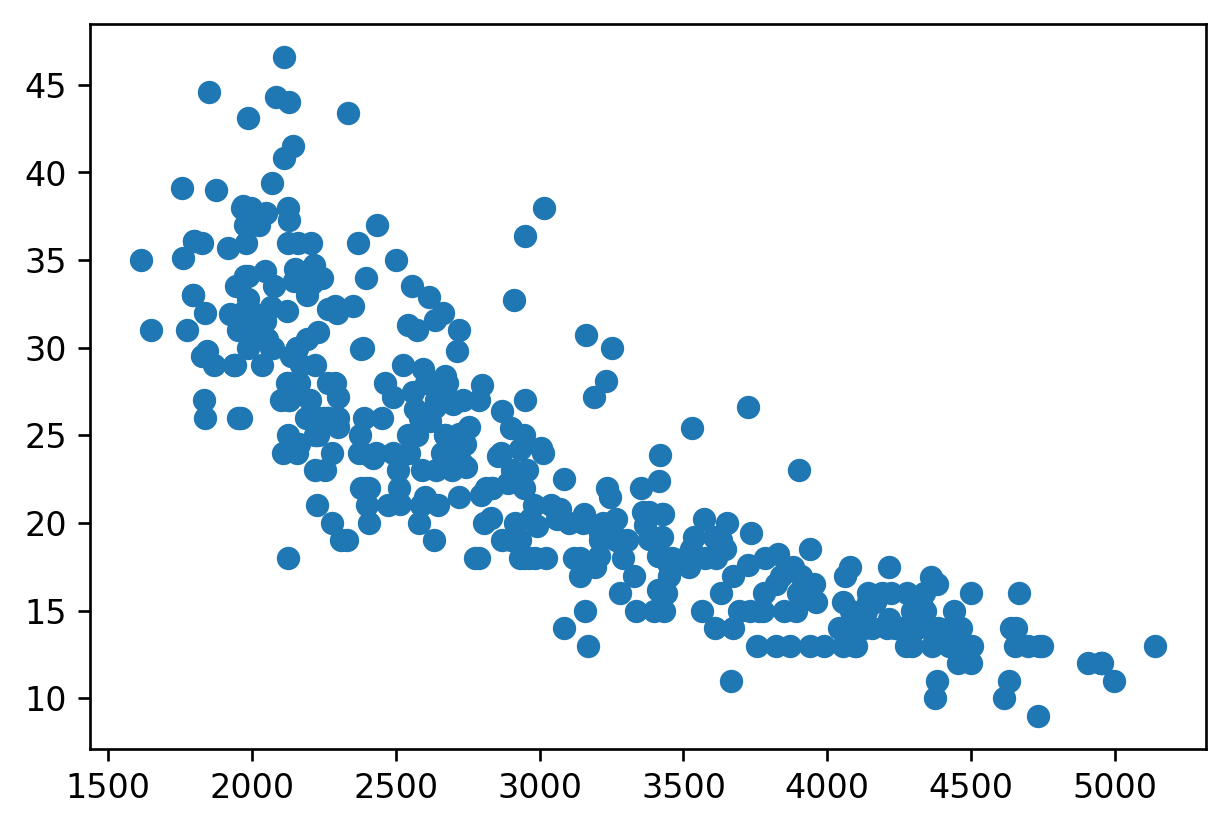

In [ ]:
plt.scatter(data['WGT'],data['MPG'])

In [ ]:
data.sort_values(by='WGT')

,MPG,CYL,ENG,WGT
53,35.000000,4,72.0,1613
142,31.000000,4,76.0,1649
339,39.099998,4,79.0,1755
341,35.099998,4,81.0,1760
52,31.000000,4,71.0,1773
...,...,...,...,...
94,12.000000,8,455.0,4951
89,12.000000,8,429.0,4952
41,12.000000,8,383.0,4955
102,11.000000,8,400.0,4997


In [ ]:
x = data['WGT'].values
y = data['MPG'].values

In [ ]:
lowess_reg(x,y,2100,tricubic,0.01)

array(27.)

In [ ]:
xnew = np.arange(1500,5500,10)

In [ ]:
yhat = lowess_reg(x,y,xnew,tricubic,80)

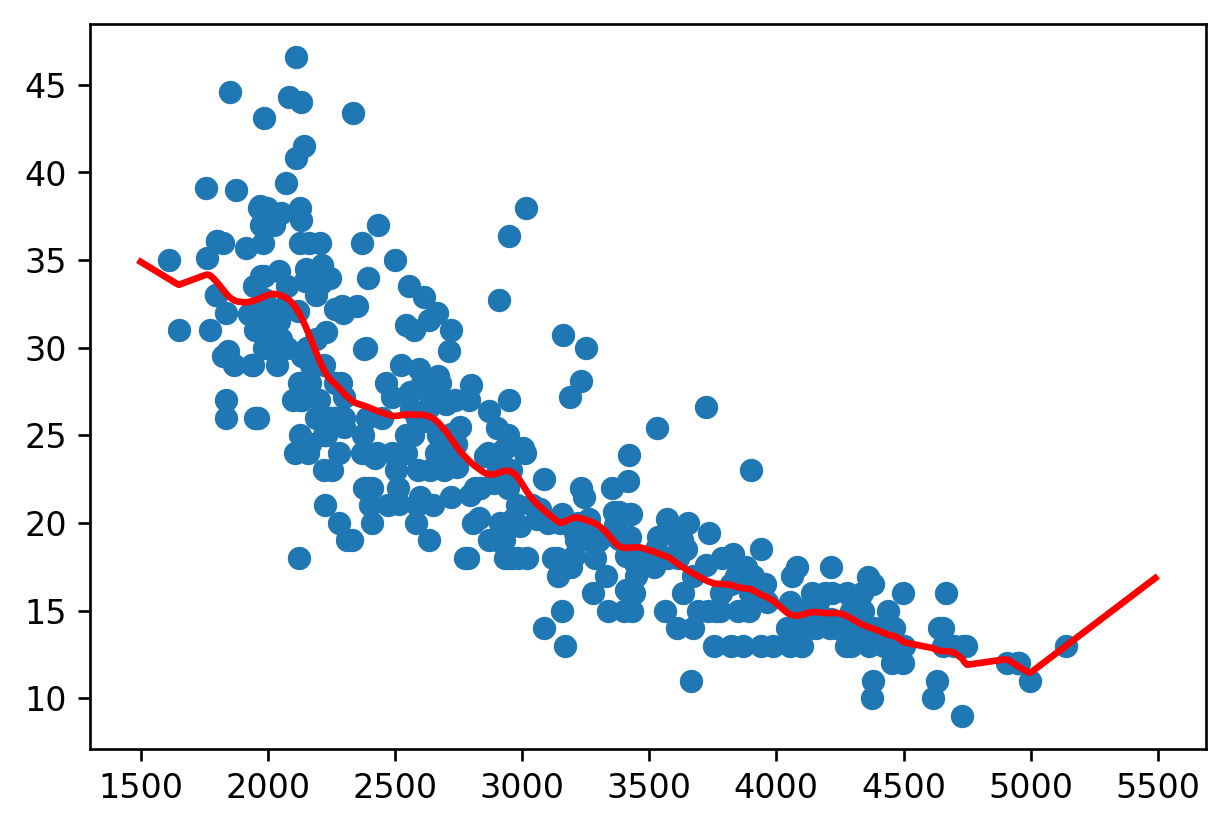

In [ ]:
plt.scatter(data['WGT'],data['MPG'])
plt.plot(xnew,yhat,color='red',lw=2)